# Comparison with other datasets

In [1]:
import functools
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import binom_test, fisher_exact, linregress

from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation
filterwarnings('ignore', category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

## BrainSeq functions

In [3]:
config = {
    'biomart': '../_h/biomart.csv',
    'caudate': '../../../caudate/_m/genes/diffExpr_maleVfemale_full.txt',
    'dlpfc': '../../../dlpfc/_m/genes/diffExpr_maleVfemale_full.txt',
    'hippo': '../../../hippocampus/_m/genes/diffExpr_maleVfemale_full.txt',
}

In [4]:
@functools.lru_cache()
def get_biomart():
    return pd.read_csv(config['biomart'], index_col=0)


@functools.lru_cache()
def get_deg(filename):
    dft = pd.read_csv(filename, sep='\t', index_col=0)
    dft['Feature'] = dft.index
    dft['Dir'] = np.sign(dft['t'])
    if 'gene_id' in dft.columns:
        dft['ensemblID'] = dft.gene_id.str.replace('\\..*', '')
    elif 'ensembl_gene_id' in dft.columns:
        dft.rename(columns={'ensembl_gene_id': 'ensemblID'}, inplace=True)
    return dft[['Feature', 'ensemblID', 'Symbol', 'adj.P.Val', 'logFC', 't', 'Dir']]


@functools.lru_cache()
def get_deg_sig(filename, fdr):
    dft = get_deg(filename)
    return dft[(dft['adj.P.Val'] < fdr)]


@functools.lru_cache()
def merge_dataframes(tissue1, tissue2):
    return get_deg(config[tissue1]).merge(get_deg(config[tissue2]), 
                                          on='Feature', 
                                          suffixes=['_%s' % tissue1, '_%s' % tissue2])


@functools.lru_cache()
def merge_dataframes_sig(tissue1, tissue2):
    fdr = 0.05
    return get_deg_sig(config[tissue1], fdr).merge(get_deg_sig(config[tissue2], fdr), 
                                                   on='Feature', 
                                                   suffixes=['_%s' % tissue1, '_%s' % tissue2])

## Trabzuni comparison

In [5]:
@functools.lru_cache()
def get_symbols(tissue, fdr):
    return get_deg_sig(config[tissue], fdr)[['Symbol']]


def tissue_annotation(tissue):
    return {'dlpfc': 'DLPFC', 'hippo': 'Hippocampus', 
            'caudate': 'Caudate', 'cmc_dlpfc': 'CMC DLPFC'}[tissue]

In [6]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labelsize=18,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [7]:
config_trabzuni = {
    'genes': '/ceph/users/jbenja13/projects/sex_sz_ria/input/public_results/extract_geneLists/_m/trabzuni_sex_diff_genes_logFC.csv',
    'annot': '/ceph/users/jbenja13/projects/sex_sz_ria/input/public_results/_m/trabzuni/trabzuni_annotation.txt',
}
    
zz = dict()
for tissue in ['caudate', 'dlpfc', 'hippo']:
    ww = []; yy = []
    fdr = 0.05
    trabzuni = pd.read_csv(config_trabzuni['genes'], index_col=0)\
                 .drop(['average ALL'], axis=1)
    annot = pd.read_csv(config_trabzuni['annot'], sep='\t', index_col=0)
    for col in trabzuni.drop('Chromosome', axis=1).columns:
        trabzuni.loc[trabzuni[col] != 0, col] = 1
        tot = len(set(trabzuni[(trabzuni[col] != 0)].index))
        overlap = len(set(get_symbols(tissue, fdr).Symbol) & 
                      set(trabzuni[(trabzuni[col] != 0)].index))
        xx = overlap / tot 
        ww.append(xx)
        yy.append(annot.to_dict()['TISSUE'][col.split(' ')[0]])
        print("There is %d (%.1f%%) overlap between %s and %s %s!" % 
              (overlap, xx* 100, tissue_annotation(tissue), 
               annot.to_dict()['TISSUE'][col.split(' ')[0]], 
               col.split(" ")[1]))
    print("")
    zz[tissue_annotation(tissue)] = ww

There is 22 (68.8%) overlap between Caudate and cerebellum (N=128)!
There is 17 (77.3%) overlap between Caudate and frontal cortex (N=122)!
There is 18 (85.7%) overlap between Caudate and hippocampus (N=114)!
There is 7 (87.5%) overlap between Caudate and hypothalamus (N=13)!
There is 20 (90.9%) overlap between Caudate and medulla (N=109)!
There is 16 (84.2%) overlap between Caudate and occipital cortex (N=125)!
There is 14 (77.8%) overlap between Caudate and putamen (N=121)!
There is 17 (89.5%) overlap between Caudate and substantia nigra (N=96)!
There is 19 (82.6%) overlap between Caudate and temporal cortex (N=114)!
There is 21 (77.8%) overlap between Caudate and thalamus (N=107)!
There is 20 (87.0%) overlap between Caudate and white matter (N=120)!

There is 21 (65.6%) overlap between DLPFC and cerebellum (N=128)!
There is 16 (72.7%) overlap between DLPFC and frontal cortex (N=122)!
There is 17 (81.0%) overlap between DLPFC and hippocampus (N=114)!
There is 6 (75.0%) overlap betwee

In [8]:
dfz = pd.DataFrame.from_dict(zz)
dfz['Tissue'] = trabzuni.drop('Chromosome', axis=1).columns
dfz = dfz.set_index('Tissue')
dfz

,Caudate,DLPFC,Hippocampus
Tissue,,,
CRBL (N=128),0.687500,0.656250,0.656250
FCTX (N=122),0.772727,0.727273,0.772727
HIPP (N=114),0.857143,0.809524,0.857143
HYPO (N=13),0.875000,0.750000,0.875000
MEDU (N=109),0.909091,0.863636,0.909091
OCTX (N=125),0.842105,0.789474,0.842105
PUTM (N=121),0.777778,0.722222,0.777778
SNIG (N=96),0.894737,0.842105,0.894737
TCTX (N=114),0.826087,0.782609,0.826087


In [9]:
dfz.to_csv('brainseq_overlap_trabzuni_fraction.txt', sep='\t')

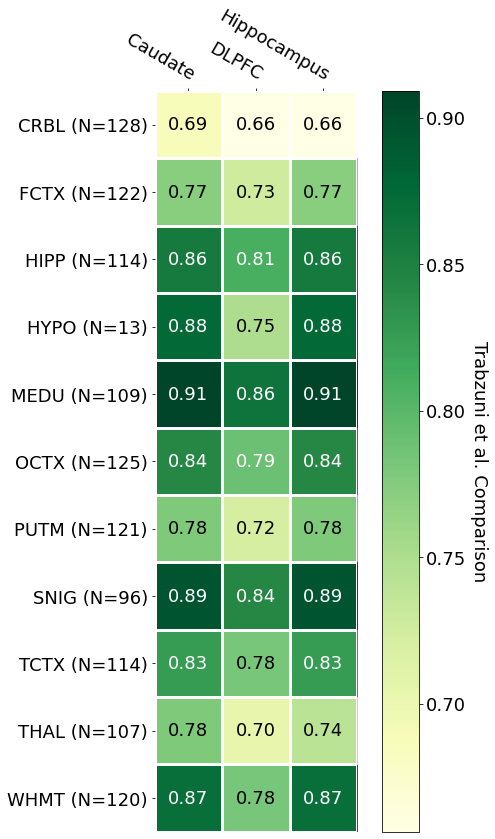

In [9]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 12))
plt.rcParams.update({'font.size': 18})
im, cbar = heatmap(dfz, dfz.index, dfz.columns, ax=ax,
                   cmap="YlGn", cbarlabel="Trabzuni et al. Comparison")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('brainseq_overlap_trabzuni_heatmap.png')
plt.savefig('brainseq_overlap_trabzuni_heatmap.pdf')
plt.savefig('brainseq_overlap_trabzuni_heatmap.svg')
plt.show()

In [11]:
df = pd.read_csv("../../upset_plots/_m/brainseq_deg_across_tissues_comparison.csv", 
                 index_col=0)

tt = get_biomart().merge(df, left_on='ensembl_gene_id', right_index=True)\
             .merge(trabzuni, left_on='external_gene_name', 
                    right_index=True, how='right')\
             .set_index('external_gene_name')

tt[['ensembl_gene_id', 'entrezgene', 'Chromosome', 'description', 
    'Caudate', 'DLPFC', 'Hippocampus', 'CRBL (N=128)', 'FCTX (N=122)',
    'HIPP (N=114)', 'HYPO (N=13)', 'MEDU (N=109)', 'OCTX (N=125)',
    'PUTM (N=121)', 'SNIG (N=96)', 'TCTX (N=114)', 'THAL (N=107)',
    'WHMT (N=120)']].to_csv('brainseq_overlap_trabzuni_genes.csv')

## Mayne comparison

In [12]:
mayne_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/public_results/extract_geneLists/_m/mayne_sex_diff_genes.csv'
mayne = pd.read_csv(mayne_file)
mayne.groupby('Version').size()

Version
all           16
autosomes    215
noY          244
dtype: int64

In [13]:
zz = dict()
for tissue in ['caudate', 'dlpfc', 'hippo']:
    ww = []; yy = []
    fdr = 0.05
    mayne = pd.read_csv(mayne_file)
    mayne['Mayne'] = 1
    for ver in ['all', 'autosomes', 'noY']:
        mm = mayne.loc[(mayne['Version'] == ver), ['Ensembl', 'Mayne']]
        tot = len(set(mm.Ensembl))
        overlap = len(set(get_deg_sig(config[tissue], fdr).ensemblID) & 
                      set(mm.Ensembl))
        xx = overlap / tot 
        ww.append(xx)
        print("There is %d (%.1f%%) overlap between %s and %s from Mayne!" % 
              (overlap, xx* 100, tissue_annotation(tissue), ver))
    print("")
    zz[tissue_annotation(tissue)] = ww

There is 14 (93.3%) overlap between Caudate and all from Mayne!
There is 6 (2.8%) overlap between Caudate and autosomes from Mayne!
There is 18 (7.4%) overlap between Caudate and noY from Mayne!

There is 13 (86.7%) overlap between DLPFC and all from Mayne!
There is 3 (1.4%) overlap between DLPFC and autosomes from Mayne!
There is 12 (4.9%) overlap between DLPFC and noY from Mayne!

There is 14 (93.3%) overlap between Hippocampus and all from Mayne!
There is 0 (0.0%) overlap between Hippocampus and autosomes from Mayne!
There is 8 (3.3%) overlap between Hippocampus and noY from Mayne!



In [14]:
dfm = pd.DataFrame.from_dict(zz)
dfm['Method'] = mayne.Version.unique()
dfm = dfm.set_index('Method')
dfm.to_csv('brainseq_overlap_mayne_fraction.txt', sep='\t')
dfm

,Caudate,DLPFC,Hippocampus
Method,,,
all,0.933333,0.866667,0.933333
autosomes,0.027907,0.013953,0.000000
noY,0.073770,0.049180,0.032787


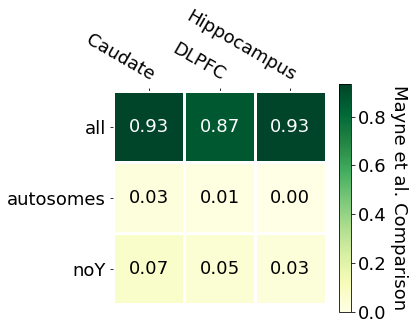

In [15]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 5))
plt.rcParams.update({'font.size': 18})
im, cbar = heatmap(dfm, dfm.index, dfm.columns, ax=ax,
                   cmap="YlGn", cbarlabel="Mayne et al. Comparison")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('brainseq_overlap_mayne_heatmap.png')
plt.savefig('brainseq_overlap_mayne_heatmap.pdf')
plt.savefig('brainseq_overlap_mayne_heatmap.svg')
plt.show()

In [16]:
df = pd.read_csv("../../upset_plots/_m/brainseq_deg_across_tissues_comparison.csv", 
                 index_col=0)

mm = mayne.loc[(mayne['Version'] == 'all'), ['Ensembl', 'Mayne']]
mm = get_biomart().merge(df, left_on='ensembl_gene_id', right_index=True)\
                  .merge(mm.set_index('Ensembl'), left_on="ensembl_gene_id", 
                         right_index=True, how='right')\
                  .set_index('external_gene_name')
mm.to_csv('brainseq_overlap_mayne_all_genes.csv')

## Gershoni and Pietrokovski (GTEx) Comparison

In [48]:
gtex_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/public_results/extract_geneLists/_m/gp_gtex_sex_diff_genes.csv'
gtex = pd.read_csv(gtex_file).rename(columns={'Ensembl': 'Gencode'}).drop('Gene', axis=1)
gtex['Ensembl'] = gtex.Gencode.str.replace("\\..*", "")
gtex.set_index('Ensembl', inplace=True)
gtex.shape

(18759, 47)

In [56]:
zz = dict()
for tissue in ['caudate', 'dlpfc', 'hippo']:
    ww = []; yy = []
    fdr = 0.05
    for col in gtex.drop(['Symbol', 'Gencode'], axis=1).columns:
        gtex.loc[gtex[col] != 0, col] = 1
        tot = len(set(gtex[(gtex[col] != 0)].index))
        overlap = len(set(get_deg_sig(config[tissue], fdr).ensemblID) & 
                      set(gtex[(gtex[col] != 0)].index))
        xx = overlap / tot 
        ww.append(xx)
        print("There is %d (%.1f%%) overlap between %s and %s GTEx!" % 
              (overlap, xx* 100, tissue_annotation(tissue), col))
    print("")
    zz[tissue_annotation(tissue)] = ww

There is 27 (10.3%) overlap between Caudate and Adipose-Subcutaneous GTEx!
There is 16 (32.0%) overlap between Caudate and Adipose-Visceral GTEx!
There is 14 (82.4%) overlap between Caudate and Adrenal_Gland GTEx!
There is 20 (62.5%) overlap between Caudate and Artery-Aorta GTEx!
There is 15 (88.2%) overlap between Caudate and Artery-Coronary GTEx!
There is 22 (59.5%) overlap between Caudate and Artery-Tibial GTEx!
There is 10 (100.0%) overlap between Caudate and Bladder GTEx!
There is 10 (76.9%) overlap between Caudate and Brain-Amygdala GTEx!
There is 14 (9.1%) overlap between Caudate and Brain-Anterior_cingulate_cortex GTEx!
There is 13 (86.7%) overlap between Caudate and Brain-Caudate GTEx!
There is 10 (83.3%) overlap between Caudate and Brain-Cerebellar_Hemisphere GTEx!
There is 15 (36.6%) overlap between Caudate and Brain-Cerebellum GTEx!
There is 10 (100.0%) overlap between Caudate and Brain-Cortex GTEx!
There is 11 (84.6%) overlap between Caudate and Brain-Frontal_Cortex GTEx!


In [30]:
dfg = pd.DataFrame.from_dict(zz)
dfg['Tissue'] = gtex.drop(['Symbol', 'Gencode'], axis=1).columns
dfg = dfg.set_index('Tissue')
dfg.to_csv('brainseq_overlap_gtex_fraction.txt', sep='\t')
dfg.head()

,Caudate,DLPFC,Hippocampus
Tissue,,,
Adipose-Subcutaneous,0.102662,0.064639,0.079848
Adipose-Visceral,0.320000,0.240000,0.300000
Adrenal_Gland,0.823529,0.764706,0.823529
Artery-Aorta,0.625000,0.562500,0.625000
Artery-Coronary,0.882353,0.764706,0.882353


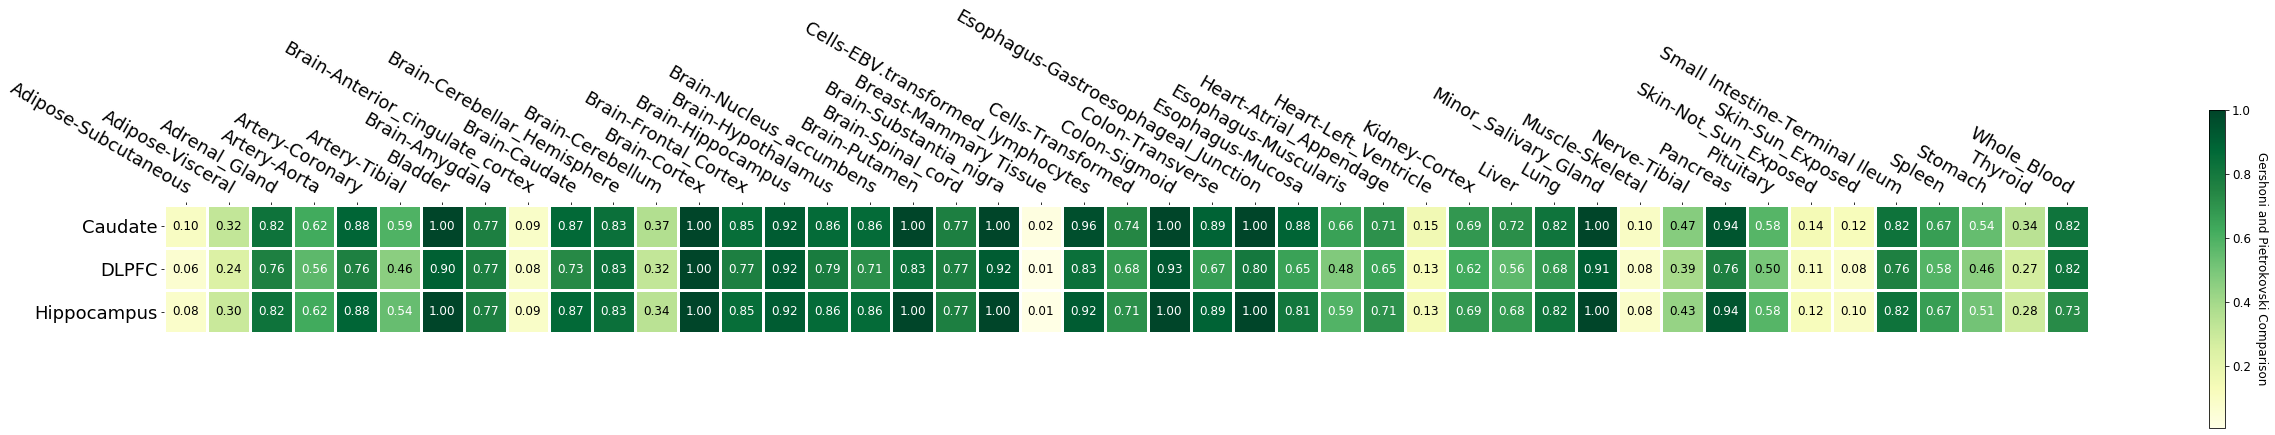

In [43]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(36, 8))
plt.rcParams.update({'font.size': 12})
im, cbar = heatmap(dfg.T, dfg.columns, dfg.index, ax=ax,
                   cmap="YlGn", 
                   cbarlabel="Gershoni and Pietrokovski Comparison")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('brainseq_overlap_gtex_heatmap_full.png')
plt.savefig('brainseq_overlap_gtex_heatmap_full.pdf')
plt.savefig('brainseq_overlap_gtex_heatmap_full.svg')
plt.show()

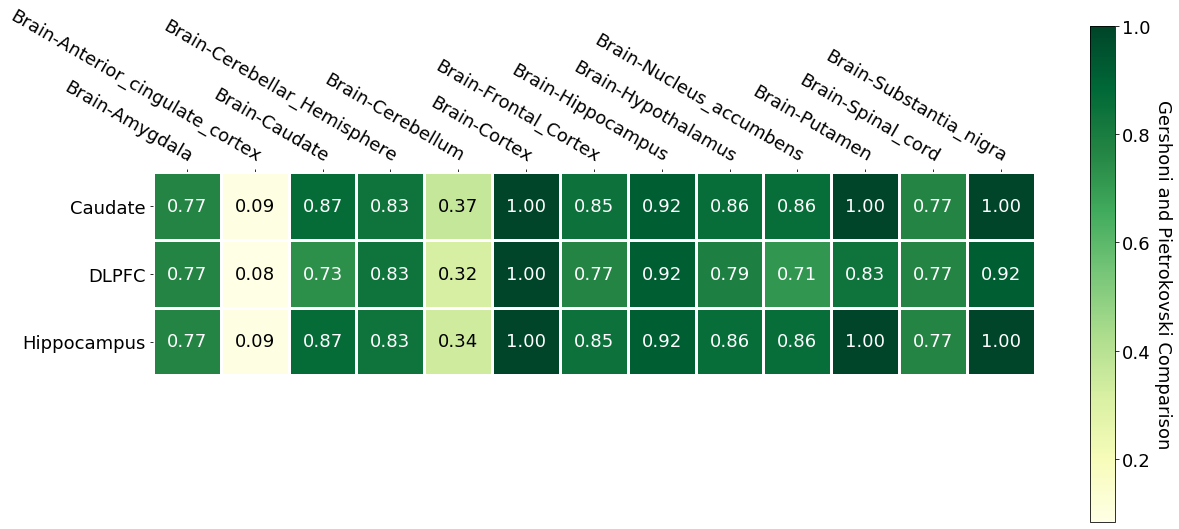

In [53]:
brain = dfg[(dfg.index.str.contains('Brain'))].copy()
fig, ax = plt.subplots(figsize=(18, 8))
plt.rcParams.update({'font.size': 18})
im, cbar = heatmap(brain.T, brain.columns, brain.index, ax=ax,
                   cmap="YlGn", 
                   cbarlabel="Gershoni and Pietrokovski Comparison")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('brainseq_overlap_gtex_heatmap.png')
plt.savefig('brainseq_overlap_gtex_heatmap.pdf')
plt.savefig('brainseq_overlap_gtex_heatmap.svg')
plt.show()

In [54]:
df = pd.read_csv("../../upset_plots/_m/brainseq_deg_across_tissues_comparison.csv", 
                 index_col=0)

gg = get_biomart().merge(df, left_on='ensembl_gene_id', right_index=True)\
             .merge(gtex.drop(['Symbol', 'Gencode'], axis=1), 
                    left_on='ensembl_gene_id', 
                    right_index=True, how='outer')\
             .set_index('external_gene_name')
gg.to_csv('brainseq_overlap_gtex_genes.csv')